In [2]:
using ExprOptimization
using TikzPictures
TikzPictures.standaloneWorkaround(true)

In [3]:
grammar = @grammar begin
    Real = x
    Real = Real * Real
    Real = Real + Real
    Real = Real - Real
    Real = _(Base.rand(1.0:5.0))
end

ExprRules.Grammar(Any[:x, :(Real * Real), :(Real + Real), :(Real - Real), :(_(Base.rand(1.0:5.0)))], Symbol[:Real, :Real, :Real, :Real, :Real], Bool[true, false, false, false, true], Bool[false, false, false, false, true], Dict(:Real=>[1, 2, 3, 4, 5]), Array{Symbol,1}[Symbol[], Symbol[:Real, :Real], Symbol[:Real, :Real], Symbol[:Real, :Real], Symbol[]])

Sample a random derivation tree

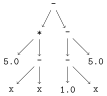

In [5]:
srand(1)
tree = rand(RuleNode, grammar, :Real, 4)
display(tree, grammar)

Get the expression encoded by the tree

In [6]:
ex = get_executable(tree, grammar)

:(5.0 * (x - x) - ((1.0 - x) - 5.0))

Define ground truth expression for symbolic regression and the loss function.

In [7]:
ground_truth(x) = x + 2
function ExprOptimization.loss(tree::RuleNode)
    ex = get_executable(tree, grammar)
    los = 0.0
    global x
    for x = -5.0:0.1:5.0
        los += abs2(eval(ex) - ground_truth(x))
    end
    los
end

Evaluate the loss function for a few test expressions.  Verify that the loss function is at a minimum when the expression matches ground truth.

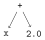

In [8]:
trees = RuleNode[]
push!(trees, RuleNode(5, 0.0))
push!(trees, RuleNode(5, 2.0))
push!(trees, RuleNode(1))
push!(trees, RuleNode(3, [RuleNode(1), RuleNode(5, 2.0)]))
display(trees[4], grammar)

In [9]:
i = 0
for t in trees
    ex = get_executable(t, grammar)
    @printf("%2d  %15s  %5f\n", i+=1, string(ex), loss(t))
end

 1              0.0  1262.500000
 2              2.0  858.500000
 3                x  404.000000
 4          x + 2.0  0.000000


Monte Carlo optimization

In [10]:
srand(1)
p = MonteCarloParams(1000, 4)
results1 = optimize(p, grammar, :Real)
(results1.expr, results1.loss)

(:(2.0 + x), 0.0)

Genetic Programming optimization

In [11]:
srand(4)
p = GeneticProgramParams(100,10,4,0.3,0.3,0.4)
results2 = optimize(p, grammar, :Real)
(results2.expr, results2.loss)

(:(x + 2.0), 0.0)